<a href="https://colab.research.google.com/github/RamkrishnaKamble000/CS726/blob/main/CS726_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install transformers
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch, logging
from transformers import ViTImageProcessor
## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms


## Basic libraries
from fastdownload import FastDownload
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler


In [26]:
## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [27]:
## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

In [28]:
## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

In [29]:
## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [30]:
## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

In [31]:
def prompt_2_img(prompts, neg_prompts=None, g=7.5, seed=100, steps=70, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding negative prompt condition
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    # Adding an unconditional prompt , helps in the generation process
    else: uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'): os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

In [32]:
x = text_enc(["A dog wearing a white hat"]) 

In [33]:
x.shape

torch.Size([1, 77, 768])

<ipython-input-31-083e4b9a0a37>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Girl with a handgloves near oven')

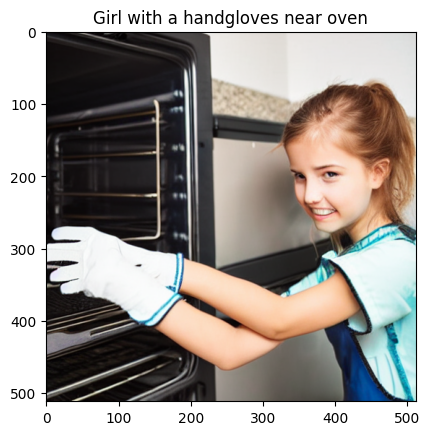

In [34]:
#Prompt to Image keeping Negative Prompts none is same as normal Prompt to image
im = prompt_2_img(prompts = ['Girl with a handgloves near oven'], neg_prompts=[""],steps=50, save_int=False)[0]
plt.imshow(im)
plt.title('Girl with a handgloves near oven')

<ipython-input-31-083e4b9a0a37>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

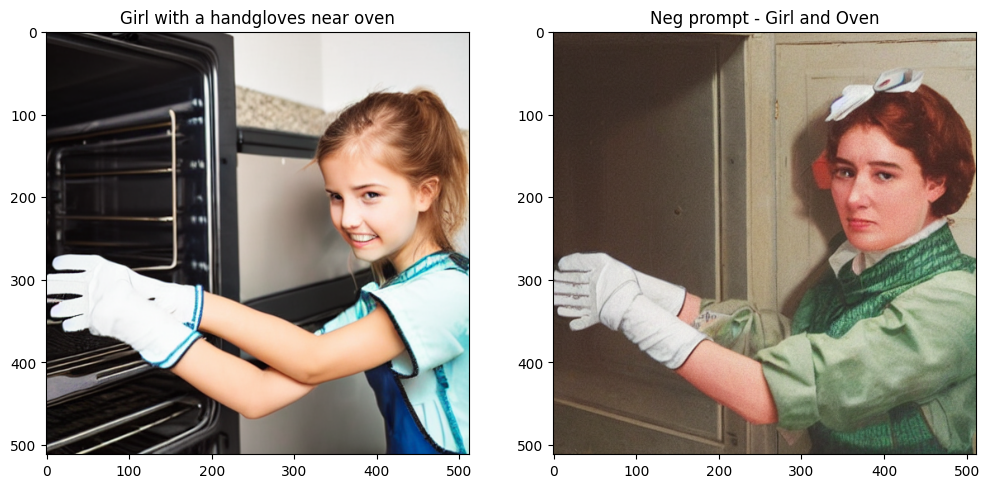

In [35]:
## Image without neg prompt
images = [None, None]
images[0] = prompt_2_img(prompts = ['Girl with a handgloves near oven'], neg_prompts=[""],steps=50, save_int=False)[0]
images[1] = prompt_2_img(prompts = ['Girl with a handgloves near oven'], neg_prompts=["Girl and Oven"],steps=50, save_int=False)[0]
    
## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate(images): 
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f'Girl with a handgloves near oven')
    else: axs[c].set_title(f"Neg prompt - Girl and Oven")

<ipython-input-31-083e4b9a0a37>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/50 [00:00<?, ?it/s]

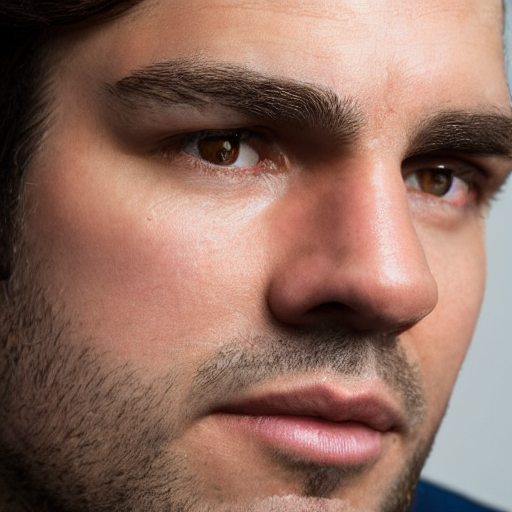

In [36]:
prompt = ['Close-up photography of the face of a 30 years old man with brown eyes, (by Alyssa Monks:1.1), by Joseph Lorusso, by Lilia Alvarado, beautiful lighting, sharp focus, 8k, high res, (pores:0.1), (sweaty:0.8), Masterpiece, Nikon Z9, Award - winning photograph']
neg_prompt = ['lowres, signs, memes, labels, text, food, text, error, mutant, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, made by children, caricature, boring, sketch, lacklustre, repetitive, cropped, (long neck), facebook, youtube, body horror, out of frame, mutilated, tiled, frame, border, porcelain skin, doll like, doll']
images = prompt_2_img(prompts = prompt, neg_prompts=neg_prompt, steps=50, save_int=False)
images[0]

### Image to Image diffusion

In [37]:
def prompt_2_img_i2i(prompts, init_img, neg_prompts=None, g=7.5, seed=100, strength =0.8, steps=50, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """

    bs = len(prompts)
    # Converting textual prompts to embedding
    text = text_enc(prompt) 

    # Adding negative prompt condition
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    # Adding an unconditional prompt , helps in the generation process
    else: uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

  0%|          | 0/20 [00:00<?, ?it/s]

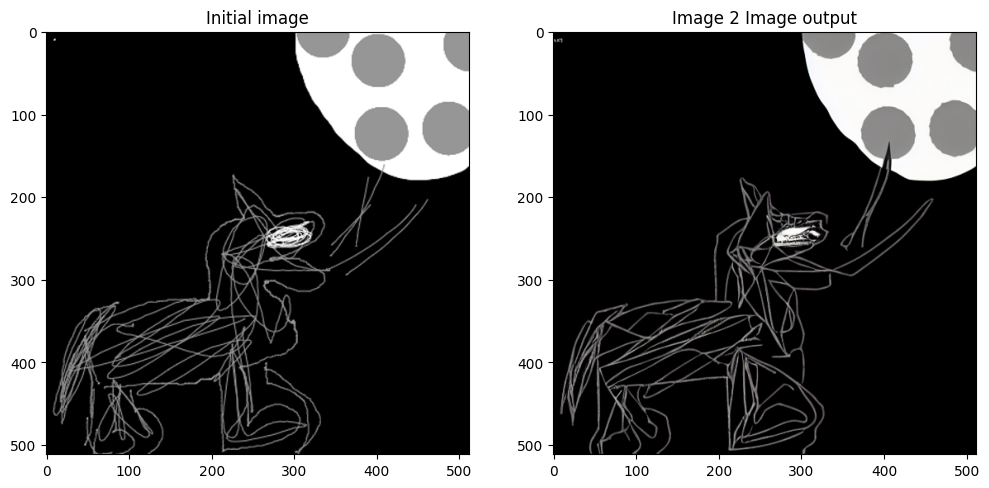

In [38]:
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
image = Image.open(p).convert('RGB').resize((512,512))
prompt = ["Wolf howling at the moon, photorealistic 4K"]
images = prompt_2_img_i2i(prompts = prompt, init_img = image,strength = 0.4)

## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate([image, images[0]]): 
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"Initial image")
    else: axs[c].set_title(f"Image 2 Image output")